## Fix

### - Split then scale!
### - Set up Validation for hp tuning & overfit control (yeah right)
### - Reverse transform 
### - Visualize y against yhat & export it to image

In [93]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Data Preprocessing 

In [95]:
df = pd.read_csv("./totaldf.csv", index_col='request_date')
df.head()

,requests,tempC,precipMM,WindGustKmph
request_date,,,,
2015-09-01 00:00:00,708,16.0,0.0,17.0
2015-09-01 01:00:00,479,16.0,0.0,17.0
2015-09-01 02:00:00,492,15.0,0.0,18.0
2015-09-01 03:00:00,563,15.0,0.0,18.0
2015-09-01 04:00:00,355,16.0,0.0,15.0


## Scale

In [96]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])
df = pd.DataFrame(df)
df.head()

C:\ProgramData\Miniconda3\envs\rasa2\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,requests,tempC,precipMM,WindGustKmph
request_date,,,,
2015-09-01 00:00:00,0.039502,0.083333,0.0,0.583333
2015-09-01 01:00:00,0.026707,0.083333,0.0,0.583333
2015-09-01 02:00:00,0.027433,0.000000,0.0,0.625000
2015-09-01 03:00:00,0.031400,0.000000,0.0,0.625000
2015-09-01 04:00:00,0.019779,0.083333,0.0,0.500000


## Train Test Split

In [36]:
def splitData(data):
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(data):
        pass
    X_train, X_test = data.iloc[train_index, :-1], data.iloc[test_index, :-1]
    y_train, y_test = data.iloc[train_index, -1], data.iloc[test_index, -1]

    # 3D reshape for Keras tensors
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
    return (X_train, X_test, y_train, y_test, train_index, test_index)
    
X_train, X_test, Y_train, Y_test, train_index, test_index = splitData(df)

## Define Model & 

In [77]:
def create_model(input_shape):
        model = Sequential()
        model.add(LSTM(50, activation='relu', 
                       return_sequences=True,  # necessary for stacked LSTM layers
                  input_shape=(input_shape[1], 
                               input_shape[2])))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))
        return model
    
model = create_model(X_train.shape)

# ? series_to_supervised missing?

## Train

In [101]:
def train(model, X_train, Y_train, X_test, Y_test, epochs=30, batch_size=36, verbose=2):
        print("==========="*5)
        print("Training LSTM model")
        print("==========="*5)
        #model = self.model
        mc = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             mode='min', verbose=0,
                             save_best_only=True)
        es = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=5)
        model.compile(loss='mse', optimizer='adam')

        history = model.fit(X_train,
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_test, y_test),
                            verbose=verbose,
                            shuffle=False,
                            callbacks=[mc])
        model.load_weights('best_model.h5')
        return history
    
history = train(model, X_train, Y_train, X_test, Y_test)

Training LSTM model
Train on 2421 samples, validate on 484 samples
Epoch 1/30
 - 4s - loss: 0.0291 - val_loss: 0.0176
Epoch 2/30
 - 0s - loss: 0.0293 - val_loss: 0.0176
Epoch 3/30
 - 0s - loss: 0.0293 - val_loss: 0.0176
Epoch 4/30
 - 0s - loss: 0.0293 - val_loss: 0.0175
Epoch 5/30
 - 1s - loss: 0.0293 - val_loss: 0.0175
Epoch 6/30
 - 0s - loss: 0.0292 - val_loss: 0.0175
Epoch 7/30
 - 1s - loss: 0.0292 - val_loss: 0.0175
Epoch 8/30
 - 0s - loss: 0.0292 - val_loss: 0.0175
Epoch 9/30
 - 0s - loss: 0.0292 - val_loss: 0.0175
Epoch 10/30
 - 0s - loss: 0.0292 - val_loss: 0.0175
Epoch 11/30
 - 0s - loss: 0.0292 - val_loss: 0.0175
Epoch 12/30
 - 0s - loss: 0.0292 - val_loss: 0.0175
Epoch 13/30
 - 0s - loss: 0.0292 - val_loss: 0.0175
Epoch 14/30
 - 0s - loss: 0.0292 - val_loss: 0.0176
Epoch 15/30
 - 0s - loss: 0.0292 - val_loss: 0.0176
Epoch 16/30
 - 0s - loss: 0.0291 - val_loss: 0.0176
Epoch 17/30
 - 0s - loss: 0.0291 - val_loss: 0.0176
Epoch 18/30
 - 0s - loss: 0.0291 - val_loss: 0.0176
Epoch 

## Visualize Train/Validation stuff

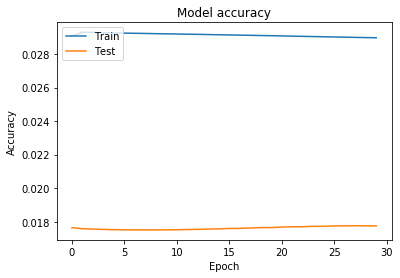

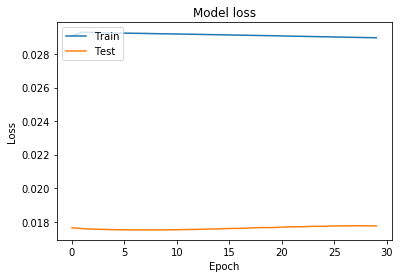

In [102]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluate Model

In [88]:
def inv_scale_pred(y, X_train, scaler):
    # inverse feature scale to get actual request values
    target_shape = (y.shape[0], X_train.shape[2]-1)
    X = np.zeros(target_shape)
    y = np.atleast_2d(y)
    inv_y = np.concatenate((X, y.reshape(-1,1)), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, -1]        
    return inv_y

def predict(model, X, X_train, scaler, scaled=True):
        yhat = model.predict(X)
        if scaled:
            return yhat
        else:
            return inv_scale_pred(yhat, X_train, scaler)

def evaluate(y, yhat, X_train, scaler, scaled=True):
        # Time diff in predictions
        yhat = yhat[1:]
        y = y[:-1]
        if scaled:
            print("Hey!")
            yhat = inv_scale_pred(yhat, X_train, scaler)
            y = inv_scale_pred(y, X_train, scaler)
        # MAE = mean_absolute_error(y, yhat)
        # RMSE = math.sqrt(mean_squared_error(y, yhat))
        #MAPE = mean_absolute_percentage_error(y, yhat)
        #print("Mean Absolute Percentage Error: {0:.2f} %".format(MAPE))
        MSE = mean_squared_error(y, yhat)
        return MSE
    


yhat = predict(model, X_test, X_train, scaler)
results = evaluate(Y_test, yhat, X_train, scaler)
results
#yhat

Hey!


ValueError: operands could not be broadcast together with shapes (483,3) (4,) (483,3) 

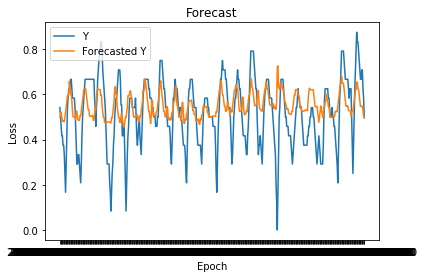

In [85]:
# Plot training & validation loss values
plt.plot(Y_test)
plt.plot(yhat)
plt.title('Forecast')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Y', 'Forecasted Y'], loc='upper left')
plt.show()

## Export performance results 

# Experiments 

In [97]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [98]:
X_train

array([[[0.03950162, 0.08333333, 0.        ]],

       [[0.02670689, 0.08333333, 0.        ]],

       [[0.02743323, 0.        , 0.        ]],

       ...,

       [[0.02542183, 0.41666667, 0.        ]],

       [[0.02531009, 0.41666667, 0.        ]],

       [[0.02916527, 0.41666667, 0.        ]]])

In [99]:
orig_X_train = scaler.inverse_transform(X_train)

ValueError: Found array with dim 3. Estimator expected <= 2.